In [39]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("poster")

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('mode.chained_assignment', None)

In [40]:
train_file = "train.csv"
initial_train = pd.read_csv(train_file)

train = initial_train[(initial_train['Year'] > 2000)]

test_file = "test.csv"
test = pd.read_csv(test_file)

In [41]:
# Set Won? to 0 or 1
train.ix[train["Won?"] == "NO", "Won?"] = 0
train.ix[train["Won?"] == "YES", "Won?"] = 1
test.ix[test["Won?"] == "NO", "Won?"] = 0
test.ix[test["Won?"] == "YES", "Won?"] = 1

In [42]:
# Set Rate to a number to better analyze it
train.ix[train["Rate"] == "G", "Rate"] = 1
train.ix[train["Rate"] == "PG", "Rate"] = 2
train.ix[train["Rate"] == "PG-13", "Rate"] = 3
train.ix[train["Rate"] == "R", "Rate"] = 4
test.ix[test["Rate"] == "G", "Rate"] = 1
test.ix[test["Rate"] == "PG", "Rate"] = 2
test.ix[test["Rate"] == "PG-13", "Rate"] = 3
test.ix[test["Rate"] == "R", "Rate"] = 4

In [43]:
train.head(5)

,Year,Movie,Won?,Budget,Opening Weekend,IMDB Rating,Genres,Woman as lead,Won Golden Globe,Won Bafta,Oscar Nominations,Golden Globe Nominations,Bafta Nominations,IMdB id,Won Producers,Won Directors,Won Actors,Racial,Rate,Metascore,Unnamed: 20
0,2015,Spotlight,1,20000000.0,295009.0,8.1,"Crime, Drama, History",0.0,0,0,6,3,3,tt1895587,0,0,1,0.0,4,93.0,NaN
1,2015,The Big Short,0,28000000.0,10531026.0,7.8,"Biography, Comedy, Drama, History",0.0,0,0,5,4,5,tt1596363,1,0,0,0.0,4,81.0,NaN
2,2015,Bridge of Spies,0,40000000.0,15371203.0,7.6,"Drama, History, Thriller",0.0,0,0,6,1,9,tt3682448,0,0,0,0.0,3,81.0,NaN
3,2015,Brooklyn,0,11000000.0,187281.0,7.5,"Drama, Romance",1.0,0,0,3,1,6,tt2381111,0,0,0,0.0,3,87.0,NaN
4,2015,Mad Max: Fury Road,0,150000000.0,45428128.0,8.1,"Action, Adventure, Sci-Fi, Thriller",0.0,0,0,10,2,7,tt1392190,0,0,0,0.0,4,90.0,NaN


In [68]:
train["Budget"].fillna(train["Budget"].median(), inplace=True)
test["Budget"].fillna(test["Budget"].median(), inplace=True)

train["IMDB Rating"].fillna(train["IMDB Rating"].median(), inplace=True)
test["IMDB Rating"].fillna(test["IMDB Rating"].median(), inplace=True)

train["Metascore"].fillna(train["Metascore"].median(), inplace=True)
test["Metascore"].fillna(train["Metascore"].median(), inplace=True)

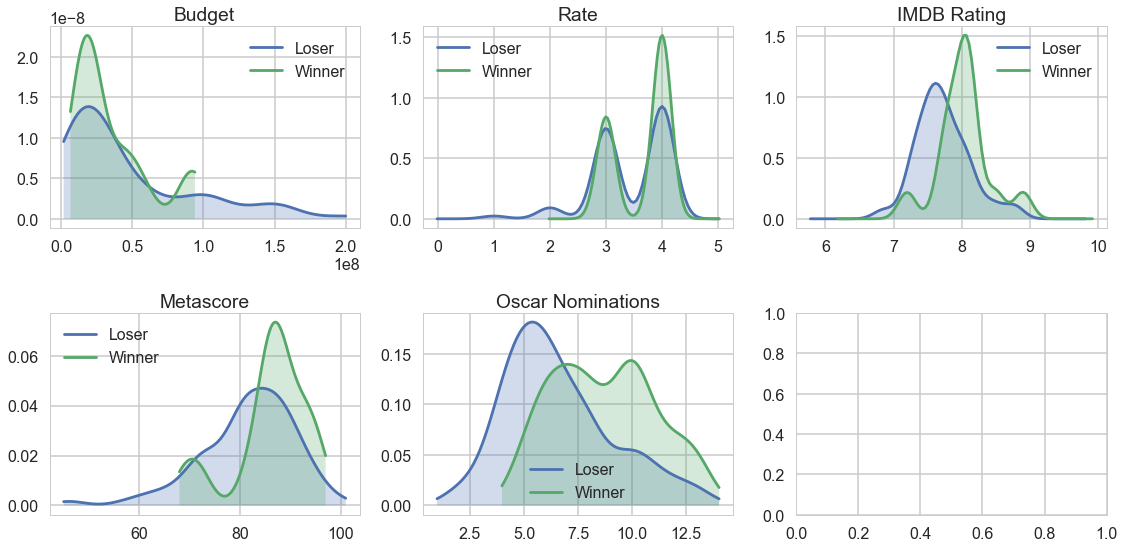

In [45]:
grouped = train.groupby('Won?')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), tight_layout=True)

for ax, p in zip(axes.ravel(), ['Budget', 'Rate', 'IMDB Rating', 'Metascore', 'Oscar Nominations']):
    for k, v in grouped[p]:
        if k == 0:
            label = "Loser"
        else:
            label = "Winner"
        sns.kdeplot(v, ax=ax, label = label, bw=0.34, shade = True)
    ax.set_title(p)

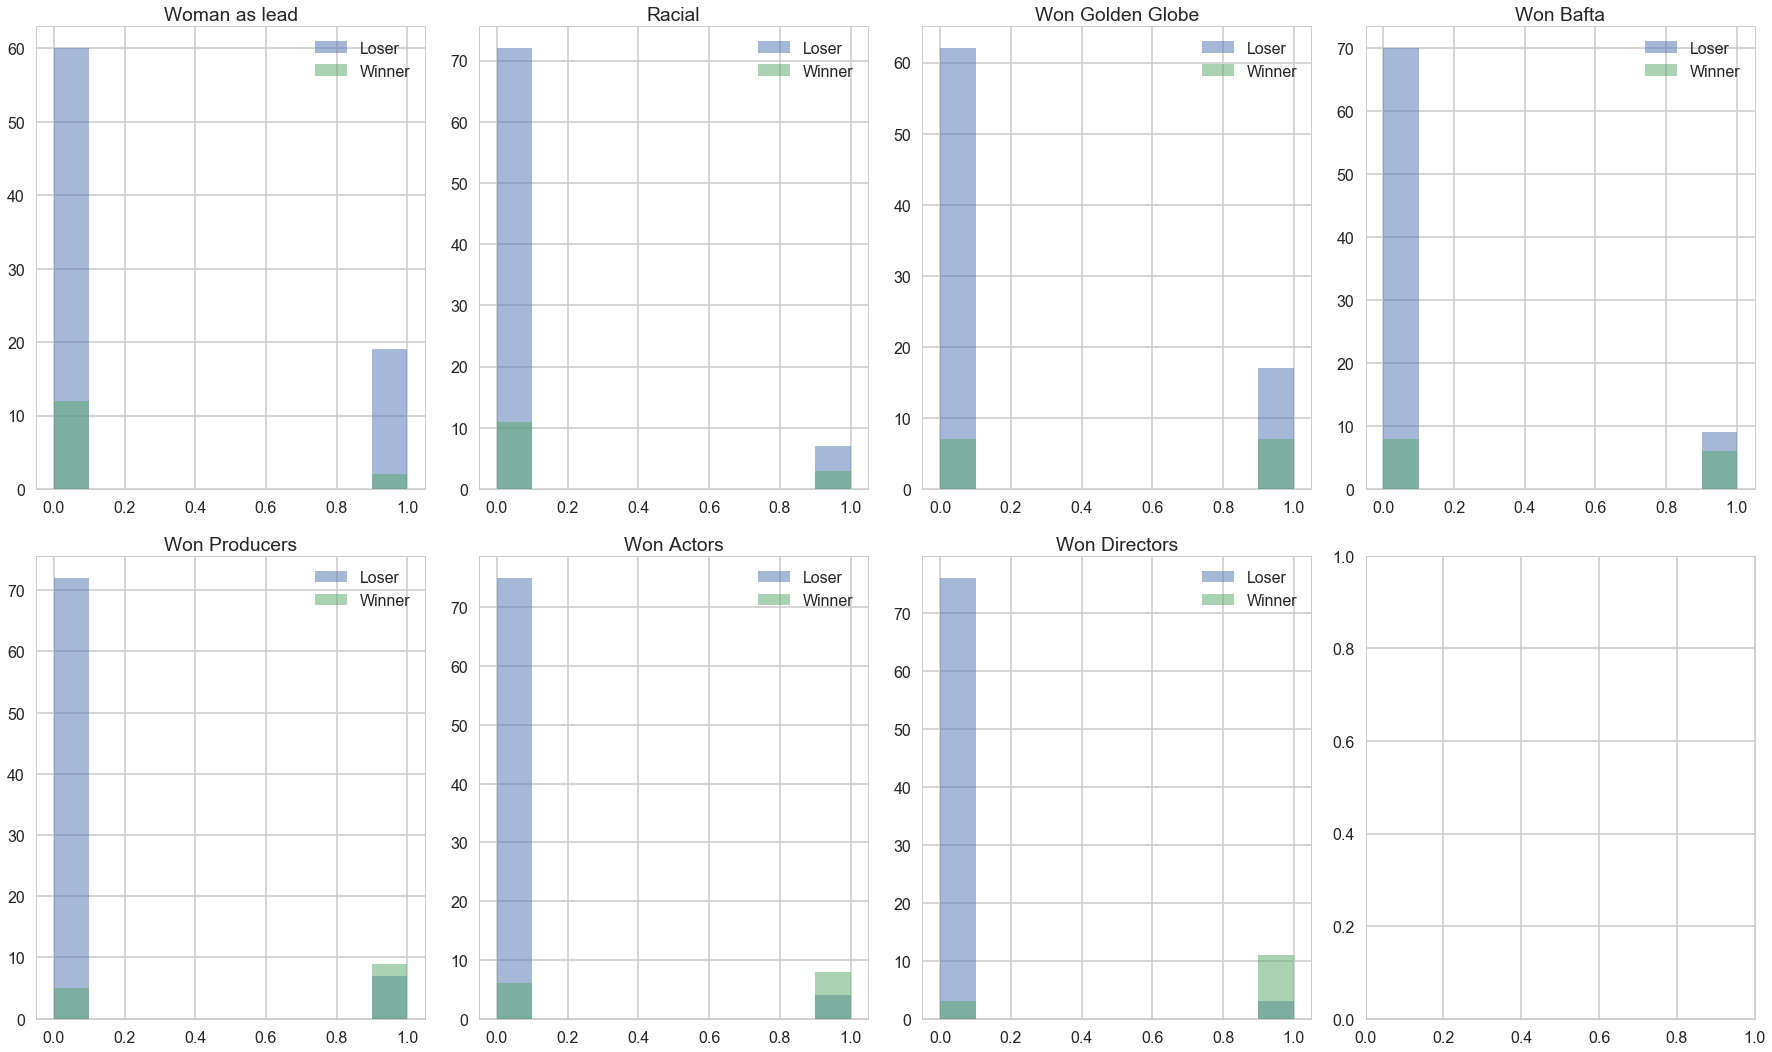

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25,15), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), ['Woman as lead', 'Racial', 'Won Golden Globe', 'Won Bafta', 'Won Producers', 'Won Actors', 'Won Directors']):
    for k, v in grouped[p]:
        if k == 0 or k == 0.0:
            label = "Loser"
        else:
            label = "Winner" 
        v.hist(ax=ax, alpha=0.5, label=label, range = [0,1])
    ax.set_title(p)
    ax.legend()

#### Random Forest Classifier

Random Forest Classifiers use many decision tree classifiers to build a classifier.  The data is randomly subset, a decision tree is built, and this process is repeated many times (10000 times in our case).  Finally the information that is gained through the many decision trees is used to create the random forest classifier

In [51]:
features = [
    "Oscar Nominations",
    "Won Golden Globe",
    "Golden Globe Nominations",
    "Won Bafta",
    "Bafta Nominations",
    "Won Producers",
    "Won Actors",
    "Won Directors",
    "Woman as lead",
    "Racial",
    "Metascore",
    "IMDB Rating"]

# "Won?" column was not created as numeric ("YES"/"NO")
target = pd.to_numeric(train["Won?"]).values
train_features = train[features].values

forest = RandomForestClassifier(
    max_depth=10, min_samples_split=2, n_estimators=100, random_state=1)
my_forest = forest.fit(train_features, target)

In [71]:
print("Train Score", my_forest.score(train_features, target))
pd.DataFrame(my_forest.feature_importances_.round(2), np.array(features), columns=["Importances"]).sort_values("Importances", ascending=False)

('Train score: ', 1.0)


,Importances
Won Directors,0.29
Won Actors,0.14
IMDB Rating,0.10
Won Producers,0.09
Metascore,0.09
Bafta Nominations,0.08
Oscar Nominations,0.07
Golden Globe Nominations,0.06
Won Golden Globe,0.02
Won Bafta,0.02


In [72]:
test_target = pd.to_numeric(test["Won?"]).values
test_features = test[features].values

print('Test Score', my_forest.score(test_features, test_target))

('Test Score', 0.88235294117647056)


In [73]:
pred_forest = my_forest.predict_proba(test_features)[:, 1]

movie_name = np.array(test["Movie"])
year = np.array(test["Year"])
won = np.array(test["Won?"])

my_solution = pd.DataFrame(pred_forest.round(2), movie_name, columns=["Winner?"])
my_solution["Year"] = year
my_solution["Actually Won?"] = won

In [74]:
normalized_solution = my_solution.copy()

for index, row in normalized_solution.iterrows():
    normalized_solution.loc[index, "Winner?"] = row["Winner?"] / my_solution["Winner?"][my_solution["Year"] == row["Year"]].sum()

In [76]:
for year in [2016, 2009, 1996, 1985, 1976]:
    print(normalized_solution[normalized_solution["Year"] == year].sort_values("Winner?", ascending=False))

                        Winner?  Year Actually Won?
La La Land             0.496241  2016             0
Hidden Figures         0.150376  2016             0
Manchester by the Sea  0.135338  2016             0
Moonlight              0.135338  2016             1
Lion                   0.052632  2016             0
Hacksaw Ridge          0.015038  2016             0
Arrival                0.007519  2016             0
Hell or High Water     0.007519  2016             0
Fences                 0.000000  2016             0
                                                  Winner?  Year Actually Won?
Inglourious Basterds                             0.426667  2009             0
The Hurt Locker                                  0.386667  2009             1
Up                                               0.066667  2009             0
Up in the Air                                    0.066667  2009             0
The Blind Side                                   0.053333  2009             0
Avatar      